##### This notebook allows Glen's A to vary to optimize modeled ice thickness by minimizing the quadratic error between observed and modeled ice thickness (following height change corrections and in situ mass balance inversion)

### named MONSTER by M. Zeuner (Mega Organized Numerical Script Transformation Executing Rapidly)

## Imports

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks, graphics

import os
import pandas as pd
import salem
import xarray as xr
import oggm
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

import oggm.cfg as cfg # could that cause problems?
import gdal
from PIL import Image as imagery
import datetime

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer


In [2]:
# Here the num variable is set:
num=2

# A list with all the glacier names
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

# Just confirm that the correct one is selected for this run of the script
print('You selected: ' , glacier[num])

You selected:  Conrad


### File names settings

In [10]:
# list with the names in the Randolf Glacier invetory (according to the glacier names above)
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']

# list with the names Lidar data (according to the glacier names above)
dem = ['20160913_kokanee_dem1_clip_slave.tif', '20150912_haig_dem_master_clip.tif', '20160912_conrad_dem1_clip_slave.tif', 'not_assigned', 
       '170917_illecillewaet_dem1_clip_slave.tif', '20170927_nordic_dem1_clip_slave.tif', '160914_zillmer_dem2.tif']

#products_directory (where the graphs and some numbers are saved for later usage)
products= '/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'

## A function to run the OGGM using mass-balance correction and (if wished) the Lidar-DEM 

This is also a function that runs the OGGM on the selected glacier and returns a thickness map for it. It uses the mass-balance correction.

In difference to the function above, this version does not use the SRTM DEM to run it but the more precise Lidar DEM which yields results closer to reality.


In [11]:
def new_mb_grad_corr_dem(num, dem, glacier, name, parameter, best, use_dem_corr):
    """
    :param num: number of selected glacier
    :param dem: list with dem file names
    :param glacier: the list with the glacier names
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :param best: if TRUE, an extra save with prefix 'best' will be created
    :param use_dem_correction: if TRUE, a Lidar DEM correction will be used
    :type num: int
    :type dem: str list
    :type glacier: str list
    :type name: str 
    :type parameter: float
    :type best: boolean
    :type use_dem_correction: boolean
    :returns: distributed thickness
    :rtype: 2D float array
    """
    
    # Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
    cfg.initialize(logging_level='WORKFLOW')

    #num determines which gdir and gradient to use, refer to list below to select desired site
    grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1


    # Get the RGI glaciers for the run.
    rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']
    rgidf = utils.get_rgi_glacier_entities(rgi_list)

    
    ############################################################# here the DEM correction happens #########################################################
    
    if(use_dem_corr==True):
    
        custom_dem_path = dem[num]

        WORKING_DIR2 = utils.gettempdir(glacier[num] + '_lidar_dem') # Let's make a working directory for this DEM 
        utils.mkdir(WORKING_DIR2, reset=True)
        cfg.initialize(logging_level='WORKFLOW')
        cfg.PATHS['working_dir'] = WORKING_DIR2

        cfg.PATHS['dem_file'] = custom_dem_path
        rgidf['DEM_SOURCE'] = 'USER'


        cfg.PARAMS['smooth_window'] = 201.
        #cfg.PARAMS['grid_dx_method'] = 'fixed'
        #cfg.PARAMS['fixed_dx'] = dx
        if glacier[num] == 'Nordic':
            cfg.PARAMS['use_intersects'] = False
        gdirs = workflow.init_glacier_regions(rgidf)


        cfg.PATHS['working_dir'] = utils.get_temp_dir('test_thick' + glacier[num])
        cfg.PARAMS['use_rgi_area'] = False
        
    else:
        cfg.PARAMS['use_intersects'] = False
        cfg.PARAMS['border'] = 10
        cfg.PATHS['working_dir'] = utils.get_temp_dir('test_thick' + glacier[num])
        cfg.PARAMS['use_rgi_area'] = False
        cfg.PARAMS[name] = parameter
        
    ###########################################################################################################################
    
    cfg.PARAMS[name] = parameter
    cfg.PARAMS['border'] = 10
    
    temporarily = [rgi_list[num]]
    rgidf = utils.get_rgi_glacier_entities(temporarily)#[rgi_list[num]]) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    gdirs = workflow.init_glacier_regions(rgidf)
    workflow.gis_prepro_tasks(gdirs)
    workflow.climate_tasks(gdirs)
    workflow.inversion_tasks(gdirs)
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

    gdir = gdirs[0]
    tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

    # Print the standard MB gradient from OGGM default
    from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
    # gdir = gdirs[num]

    mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
    z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
    mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

    # grad_line = np.polyfit(mb_on_z,z,2)
    from scipy import stats 
    slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
    print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

    # See the result of the inversion
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

    ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
    ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

    ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
    ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)


    # Let's apply a linear MB instead
    from oggm.core.climate import apparent_mb_from_linear_mb


    workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

    from oggm.core.massbalance import LinearMassBalance

    params = gdir.read_pickle('linear_mb_params')
    print(params)

    l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
    l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

    slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
    print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
    slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
    print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

    ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
    ds_new.close() 
   

    ########### gather more detailed information about the glacier ##############
    df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
    volume=df['inv_volume_km3']
    
    mfl=gdir.read_pickle('model_flowlines')
    thickness= mfl[-1].surface_h - mfl[-1].bed_h
    thickness=thickness[thickness>0].mean()
    
    ############## write it into txt file: #################
    
    if(best):
        file= open(products+'best_dem_corr_run_of_'+glacier[num]+'_with_modified_' + name+'.txt', mode='w')
    else:
        file= open(products+'dem_corr_run_of_'+glacier[num]+'_with_modified_' + name+'.txt', mode='w')
    
    file.writelines(['Run of the DEM corrected model on ' + glacier[num]+' on ', str(datetime.datetime.now()), '\n'])
    file.write('parameter modified: '+name+'\n')
    file.write('parameter value: '+str(parameter)+'\n')
    file.write('glacier total volume: '+str(volume)+' km^3 \n \n \n')
    file.write('mean thickness value: '+str(thickness)+' m \n')
    file.close()
    ##########################################################
    
    return ds_new.distributed_thickness

## Comparing DEM-corrected model with non-DEM-corrected model:

- first we run the 'new_mb_grad' function
- then we run the 'new_mb_grad_corr_dem' function
- and then we subtract the thickness maps and can see where the usage of Lidar data actually impacted the outcome of the model

In [11]:
# run the model without DEM correction
new_mb_gradient= new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, False)

# plot it as a map
new_mb_gradient.plot()
plt.title(glacier[num]+' standard settings thickness map')
# and save it
plt.savefig('/home/pelto/Desktop/ice_thick/products'+'standard_map_'+ glacier[num]+'.png', dpi=100)

# replace 'nan' by  0
new_mb_gradient=new_mb_gradient.fillna(0)

if glacier[num]=='Washmawapta':
    # make a copy for comparison reasons later on
    new_mb_gradient_corr_dem=new_mb_gradient

2019-10-22 14:30:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-10-22 14:31:01: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-22 14:31:01: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-10-22 14:31:02: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-22 14:31:02: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-22 14:31:02: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-22 14:31:02: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-22 14:31:02: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-10-22 14:31:02: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.349607    intercept: 2638.872605   R-squared: 0.999759
{'ela_h': 2528.207761747156, 'grad': 7.95}
slope default: 0.349607    intercept: 2638.872605   R-squared: 0.999759
slope: 0.125786    intercept: 2528.207762   R-squared: 1.000000


FileNotFoundError: [Errno 2] No such file or directory: 'products/Washmawapta/dem_corr_run_of_Washmawapta_with_modified_ice_density.txt'

2019-10-08 21:45:48: oggm.cfg: Using configuration file: /srv/conda/envs/notebook/lib/python3.6/site-packages/oggm/params.cfg
2019-10-08 21:45:51: oggm.cfg: Using configuration file: /srv/conda/envs/notebook/lib/python3.6/site-packages/oggm/params.cfg
2019-10-08 21:45:51: oggm.workflow: Execute entity task define_glacier_region on 7 glaciers
2019-10-08 21:45:51: oggm.workflow: Multiprocessing: using all available processors (N=2)
2019-10-08 21:45:56: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-08 21:45:56: oggm.workflow: Multiprocessing: using all available processors (N=2)
2019-10-08 21:45:56: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-08 21:45:56: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-08 21:45:56: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-08 21:45:56: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-08 21:45:56

slope: 0.242240    intercept: 2652.447411   R-squared: 0.999459


2019-10-08 21:46:00: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-08 21:46:00: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2599.1801740646565, 'grad': 6.84}
slope default: 0.242240    intercept: 2652.447411   R-squared: 0.999459
slope: 0.146199    intercept: 2599.180174   R-squared: 1.000000


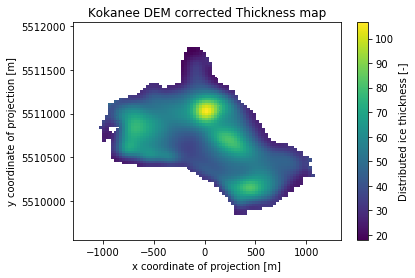

In [6]:
# run the model with DEM correction
new_mb_gradient_corr_dem= new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, True)

# plot it as a map
new_mb_gradient_corr_dem.plot()
plt.title(glacier[num]+' DEM corrected Thickness map')

# and save it
plt.savefig(products+'dem_corr_standard_map_'+ glacier[num]+'.png', dpi=100)

# replace 'nan' by  0
new_mb_gradient_corr_dem=new_mb_gradient_corr_dem.fillna(0)

# make a copy for comparison reasons later on
new_mb_gradient_corr_dem_copy=new_mb_gradient_corr_dem

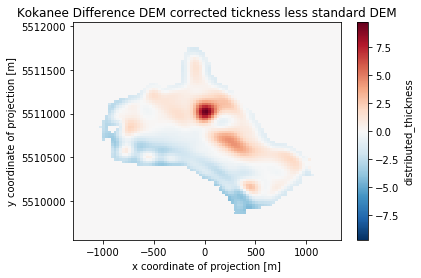

In [7]:
# the actual differencing and plotting
(new_mb_gradient_corr_dem-new_mb_gradient).plot()

# label it, save it
plt.title(glacier[num]+' Difference DEM corrected tickness less standard DEM')
plt.savefig(products+'difference_dem_correction_'+ glacier[num]+'.png', dpi=100)

## Parameter optimization

We want to run the Model with different values for a certain parameter. Therefore we define a few functions that will iterate over a sequenze of paramter values and allow us to compare the outcome to the observation data by displaying their respective squared residuals

In [8]:
def run_with_parameter(num,dem, glacier, name, parameter):
    """
    :param num: number of selected glacier
    :param dem: list with dem file names
    :param glacier: the list with the glacier names
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :type num: int
    :type dem: str list
    :type glacier: str list
    :type name: str 
    :type parameter: float
    :returns: distributed thickness
    :rtype: 2D float array
    """
    
    # just to be 100% sure, we are setting the most common parameters to their presettings in order to only vary the desired parameter
    
    cfg.PARAMS['ice_density'] = 900
    cfg.PARAMS['trapezoid_lambdas'] = 0.2
    cfg.PARAMS['mixed_min_shape'] = 0.001
    cfg.PARAMS['downstream_min_shape'] = 0.0001
    cfg.PARAMS['mu_star_halfperiod'] = 15
    cfg.PARAMS['tstar_search_glacierwide'] = False
    cfg.PARAMS['border'] = 10
    cfg.PARAMS['glen_a'] = 2.4e-24
    cfg.PARAMS['inversion_glen_a'] = 2.4e-24
    cfg.PARAMS['default_parabolic_bedshape'] = 0.003
    cfg.PARAMS['use_shape_factor_for_fluxbasedmodel'] = ''
    
    #change the parameter (not sure, whether it has any effect here...)
    cfg.PARAMS[name] = parameter

    # run the model (in this case with DEM correction)
    outcome=new_mb_grad_corr_dem(num, dem, glacier, name, parameter, False, use_dem_correction).fillna(0)

    #return the thickness distribution
    return outcome

## Definitions

In [9]:

# deletes the rows and lines that do only carry zeros for the sake of getting the right resolution 
# in order to rasterize the observation data to the same resolution and getting perfectly fitting arrays
def delete_nodata(data):
    """
    :param data: distributed thickness with 'nan' or '0' in it
    :type data: 2D floar array
    :returns: distributed thickness
    :rtype: 2D float array
    """
    
    # get a numpy array out of it
    data=data.values

    #get the spots were actual values are
    coordinates=np.nonzero(data)
    
    # create a fresh array of the minimal shape to contain all non-zero values
    result=np.zeros(((1+np.max(coordinates[0])-np.min(coordinates[0])) ,(1+np.max(coordinates[1])-np.min(coordinates[1]))))

    # fill it with the values
    for i in range(0, len(coordinates[0])):
        result[coordinates[0][i]-np.min(coordinates[0])][coordinates[1][i]-np.min(coordinates[1])]=data[coordinates[0][i]][coordinates[1][i]]
    
    # flip it and rotate it by pi
    return np.flip(np.rot90(result,2))

In [10]:
# a simple function to open the observation data and return it as an array
def read_obs_data(path):
    """
    :param path: distributed thickness with 'nan' or '0' in it
    :type path: str
    :returns: measurement points as an array
    :rtype: 2D float array
    """
    src_obs = gdal.Open(path)
    return src_obs.ReadAsArray()

## Data Import

In [11]:
# We open the observation data for the respective glacier and print out the shape and compare it with the shape of the OGGM:

obs_data = read_obs_data('obs_data_' +glacier[num]+'.tif')

if obs_data.shape == delete_nodata(new_mb_gradient_corr_dem).shape:
    print('Fantanstic, bot arrays have the same shape of: ' ,obs_data.shape )
else:
    print('Oh, Oh! Something went wrong because the observation data has the shape ' ,obs_data.shape , ' and the OGGM out put has a shape of: ' ,delete_nodata(new_mb_gradient_corr_dem).shape )



Fantanstic, bot arrays have the same shape of:  (66, 73)


# Layover-Control

This is a checking tool for adjusting the orientation of the observation data with respect to the model shapefile (in order to make it fit, we had to flip and rotate it in the 'delete_nodata' function). The resolution is not great but is should give an optical feedback on the fit. 

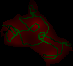

In [12]:
# run the delete_nodata function on one of the recent outputs and save it in a temporay variable
temp=delete_nodata(new_mb_gradient_corr_dem)

# get its shape
h,w = temp.shape

# create a new array with zeros and of same size
data = np.zeros((h, w, 3), dtype=np.uint8)

# and get the data point coordinates
nonzero=np.nonzero(temp)

# run through the OGGM output and write into the array as RED color code
for i in range(0,len(nonzero[0])):
    data[nonzero[0][i]][nonzero[1][i]]= [temp[nonzero[0][i]][nonzero[1][i]], 0, 0]
    
# run through the observation data and write into the array as GREEN color code
for i in range(0,len(np.nonzero(obs_data)[0])):
    data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]]= [0, obs_data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]], 0]
    
# save and show
img = imagery.fromarray(data, 'RGB')
img.save(products+ 'overlay_test_'+ glacier[num]+ '.png')

from IPython.display import Image
Image(filename=products+'overlay_test_'+ glacier[num]+ '.png', width=400) 

## Quadratic Error


We want a function that gives us the accumulated quadratic residuals of the observation data compared to the OGGM output. Because we may have very few points that are assigned a measurement but do not locate on the OGGM glacier, we have to do a little extra: We count those pixels, print their share on the entire quadratic errors and subtract their errors from the result in order not to confuse the optimization process later on. However, their share usually is below 1-2% - their impact therefore limited. This is only done for checking and consistency reasons

In [13]:
def quadratic_errors(obs_data, mesharray):
    """
    :param obs_data: array with measured values on respective spots
    :param mesharray: distributed thickness of the model output (should have same shape as obs_data)
    :type obs_data: 2D float array
    :type mesharray: 2D float array
    :returns: quadrativc error (problems corrected)
    :rtype: float
    """
    
    # counts number of "problematic" pixels
    count=0
    
    # coordinates of the data points
    coordinates=np.nonzero(obs_data)
    
    # accumulated 'problematic pixel' quadratic error
    problems=0
    
    # total accumulated quadratic error
    err=0

    # we go through all the measured points and accumulate the squared differences to the OGGM at that point
    for i in range(0,len(coordinates[0])):
        
        # if however, the OGGM shows a thickness of zero there, this seems to be a "problematic" pixel 
        if mesharray[coordinates[0][i]][coordinates[1][i]]==0:
            
            # add to problems share
            problems=problems+obs_data[coordinates[0][i]][coordinates[1][i]]**2
            
            # increment problem number
            count=count+1
        
        # add squared difference
        err=err+(obs_data[coordinates[0][i]][coordinates[1][i]]-mesharray[coordinates[0][i]][coordinates[1][i]])**2
   
    # outprint of details on "problematic" pixels
    print('found ', count , ' problem(s) within a total number of data point of: ', len(coordinates[0]), ' problem share ', problems/err,)
    
    print('corrected quadratic error is: ', err-problems)
    return (err-problems)

In [14]:
# a function that runs the (DEM-corrected) OGGM and uses the quadratic_errors function to return the quadratic errors
def master_analysis(name, parameter, obs_data, glacier, num):
    """
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :param obs_data: measured data points
    :param glacier: the list with the glacier names
    :param num: number of selected glacier
    :type name: str
    :type parameter: float
    :type obs_data: 2D float array
    :type glacier: str list
    :type num: int
    :returns: quadratic errors
    :rtype: float
    """
    quadmesh= run_with_parameter(num, dem, glacier, name, parameter)
    mesharray = delete_nodata(quadmesh)
    
    return quadratic_errors(obs_data, mesharray)

# this function takes in the name of the parameter that is to be modified and a float list of the values for whose the OGGM is 
# to be run and the quadratic errors to be calculated. It returns an array with those values and their respective quadratic errors
def optimize(name, values, obs_data, glacier, num):
    """
    :param name: name of the parameter to be modified
    :param values: values of the parameter to be modified
    :param obs_data: measured data points
    :param glacier: the list with the glacier names
    :param num: number of selected glacier
    :type name: str
    :type values: float list
    :type obs_data: 2D float array
    :type glacier: str list
    :type num: int
    :returns: [values, quad_errors]
    :rtype: float array
    """
    
    # here we store the original parameter value
    temp= cfg.PARAMS[name]
    
    #an array to store the quadratic errors in
    quad_errors=[]
    for i in range(0,len(values)):
        quad_errors.append(master_analysis(name, values[i], obs_data, glacier, num))
        
    # and here we reset it to the default value
    cfg.PARAMS[name] = temp
    
    return [values, quad_errors]

## Enter the parameter, interval and number of points that you want to get the quadratic error from 

The parameter intervall will be a linearly spaced sequence from min_value to max_value with number_of_steps steps.

Also, choose, whether you prefer to run the iteration with the DEM correction. In the most cases it is strongly recommended to do so.

In [12]:
parameter_name='inversion_glen_a'
max_value=0.1e-24
min_value=54e-24
number_of_steps=10

use_dem_correction=True

## The actual iteration takes place here

%%capture supresses the output, which is quite annoying if the OGGM runs several dozen times. But if you want to watch it work, go for it and delete that line.

Apart from that, we basically run the optimize function

In [16]:
%%capture
to_plot=optimize(parameter_name,np.linspace(min_value, max_value, number_of_steps), obs_data ,glacier, num)

Now, we plot the quadratic errors as a function of the parameter values. We also print out the minimum.

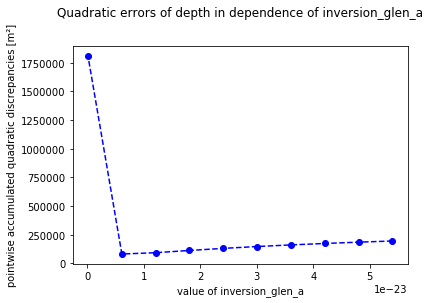

Minimal value is 82453.83677709052 at inversion_glen_a = 6.0889e-24


In [17]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 30
plt.plot(to_plot[0],to_plot[1],linestyle='--', marker='o', color='b')
plt.xlabel('value of '+parameter_name)
plt.ylabel('pointwise accumulated quadratic discrepancies [m²]')
plt.title('Quadratic errors of depth in dependence of ' +parameter_name)
 
# save it
plt.savefig(products+'quadratic_errors_'+parameter_name+'_from_'+str(min_value)+'_to_'+str(max_value)+'_'+ glacier[num]+'.png', dpi=100)

plt.show()

#small minimum function
x=0
for i in range(0,len(to_plot[1])):
    if to_plot[1][i]==np.min(to_plot[1]):
        x=i

# print out
print('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))

## Deep analysis of best parameter value

Enter the value of the given Paramter, that yields a minimum in quadratic errors

In [13]:
# take the minimum from above
#best_value=to_plot[1][x]

# select it manually
best_value=8.095e-24  #1.417e-25

Now, we run the model with the best parameter value to create seperate saves and a deep analysis

2019-11-04 12:58:11: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-04 12:58:13: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-04 12:58:13: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-04 12:58:13: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-04 12:58:13: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-04 12:58:13: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-04 12:58:13: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-04 12:58:14: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-04 12:58:15: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.237357    intercept: 2623.494608   R-squared: 0.990999


2019-11-04 12:58:17: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-04 12:58:17: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2547.652908743149, 'grad': 7.11}
slope default: 0.237357    intercept: 2623.494608   R-squared: 0.990999
slope: 0.140647    intercept: 2547.652909   R-squared: 1.000000


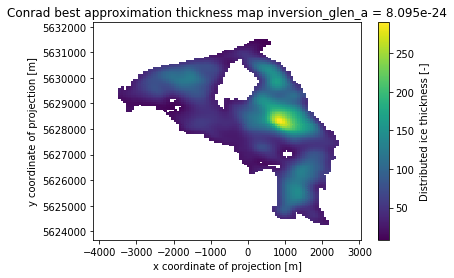

In [15]:
best_model= new_mb_grad_corr_dem(num, dem, glacier, parameter_name, best_value, True, False)

best_model.plot()
plt.title(glacier[num]+' best approximation thickness map ' + parameter_name + ' = ' +str(best_value))
plt.savefig(products+'dem_corr_best_map_'+ glacier[num]+'.png', dpi=100)
#best_model=new_mb_gradient_corr_dem.fillna(0)

In [16]:
# plot and save
(best_model-new_mb_gradient_corr_dem_copy).plot()
plt.title(glacier[num]+' Difference '+ parameter_name+ ' corrected less uncorrected thickness map (both DEM corrected)')
plt.savefig(products+'difference_'+ parameter_name + '_corrected_vs_uncorrected_'+ glacier[num]+'.png', dpi=100)

NameError: name 'new_mb_gradient_corr_dem_copy' is not defined

In [25]:
ds_new = xr.open_dataset('/tmp/OGGM/test_thickConrad/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/gridded_data.nc')
ds_new

<xarray.Dataset>
Dimensions:                (x: 106, y: 125)
Coordinates:
  * x                      (x) float32 -4127.7085 -4059.7085 ... 3012.2915
  * y                      (y) float32 5632134.5 5632066.5 ... 5623702.5
Data variables:
    topo                   (y, x) float32 ...
    topo_smoothed          (y, x) float32 ...
    glacier_mask           (y, x) int8 ...
    glacier_ext            (y, x) int8 ...
    glacier_ext_erosion    (y, x) int8 ...
    ice_divides            (y, x) int8 ...
    slope                  (y, x) float32 ...
    aspect                 (y, x) float32 ...
    slope_factor           (y, x) float32 ...
    dis_from_border        (y, x) float32 ...
    distributed_thickness  (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    proj_srs:       +proj=tmerc +lat_0=0.0 +lon_0=-116.92973613761615 +k=0.99...
    max_h_dem:      3244.0
    min_h_dem:      1238.0
    max_h_glacier:  3204.0
    min_h_glacier:  185

In [45]:
dem = ds_new['topo']
thick = ds_new['distributed_thickness']

# convert 2-d elevation and SWE arrays to 1-D vectors using ravel function
Zvec = np.ravel(dem)
Depthvec = np.ravel(thick)
# Velvec = np.ravel(vel)

bins = range(1400,3700,100)#(1400,3700,10) 

df = pd.DataFrame({"Z":Zvec,"Depth":Depthvec})

# classify the elevation data into 100 metre bins and add to the data frame 
df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1450, 3650, 100))#(1405, 3695, 10))  #

## get some statistics from the data
## this will be series which can be a pain to work with 
## so convert to dataframes
mean = df.groupby(by='Zbins')['Depth'].mean()
iqr    = df.groupby(by='Zbins')['Depth'].quantile(0.75) - df.groupby(by='Zbins')['Depth'].quantile(0.25)
count  = df.groupby(by='Zbins')['Depth'].count()

## remove any values that are less than 100 values
## these are series not pandas dataframes

## convert series to pandas data frames instead of series

mean = mean.to_frame() 
iqr    = iqr.to_frame()
count  = count.to_frame()

## Make combine data frame

mean['iqr']   = iqr
mean['count'] = count

# ## remove any rows where count is below set threshold
# mean[mean['count'] < n_min] = np.nan

mean = mean.dropna()

## reset index to make Zbins a column rather than an index
mean          = mean.reset_index()
mean['Zbins'] = mean['Zbins'].tolist()

# ## returns data frame 
# return mean 


In [46]:
mean


,Zbins,Depth,iqr,count
0,1845,8.930145,0.000000,1
1,1855,8.901881,0.284359,2
2,1865,8.466455,0.208502,2
3,1875,9.452811,0.360853,3
4,1885,10.506420,0.270571,2
5,1895,11.394094,0.667385,3
6,1905,12.563551,0.258026,3
7,1915,14.001060,0.554924,2
8,1925,14.704309,1.395737,2
9,1935,15.258923,1.070421,2


In [47]:
mean.to_csv('/home/pelto/Desktop/ice_flux/' + glacier[num] + '_optimized_thickness_binned.csv')